In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import tomosipo as ts
from ts_algorithms import fbp, tv_min2d
from torch import nn

from autodiffCT.operator import BaseOperator
import autodiffCT.pipeline as cxpl
import autodiffCT.optimizer as ctxopt
import autodiffCT.parameter as ctxpar
from autodiffCT.nn import PyTorchNn2dOperator
from autodiffCT.tomography.reconstruction import TvMinOperator, PyTorchFbpOperator
from autodiffCT.operator.graph import VoidOperator

from tqdm import trange


def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.cpu().numpy()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()
    plt.show()

/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get date to date the saves:
from datetime import datetime
import os

date_str = datetime.today().strftime('0%Y-%m-%d')
path = 'experimental_results/'+date_str +'/'

# Meceake directory if it does not exist
folder = os.path.dirname(path)
if not os.path.exists(folder):
    os.makedirs(folder)

# Create test data (skip in principle)

In [4]:
np.set_printoptions(precision=8)
torch.set_printoptions(precision=8)

if torch.cuda.is_available():np.set_printoptions(precision=8)
torch.set_printoptions(precision=8)

if torch.cuda.is_available():
    dev = 'cuda'
else:
    raise Exception("No GPU available")

###  CREATE PHANTOM AND DATA  ###

# Fix seed for reproducibility
random_seed = 12345

already_generated = True
if not already_generated:
    ## This is not strictly necessary, only if you want to generate your own foam phantoms.
    import foam_ct_phantom
    from xdesign import Foam, discrete_phantom, SimpleMaterial
    import matplotlib.pyplot as plt
    
    # Note that nspheres_per_unit is set to a low value to reduce the computation time here.
    # The default value is 100000.
    foam_ct_phantom.FoamPhantom.generate('test_phantom_bla.h5',random_seed,nspheres_per_unit=1000, zrange=0.1)
    phantom_obj = foam_ct_phantom.FoamPhantom('test_phantom_bla.h5')
    geom = foam_ct_phantom.VolumeGeometry(vsize, vsize, 1, 3/vsize)
    phantom_obj.generate_volume('test_foam_vol.h5', geom)
    phantom = foam_ct_phantom.load_volume('test_foam_vol.h5')
    phantom = torch.tensor(phantom)
    plot_imgs(phantom=phantom)

    for i in range(1,102):
        p = Foam(size_range=0.1, gap=0.01)
        p.sprinkle(counts=80, radius=0.02, gap=0.01, material=SimpleMaterial(-1.0))
        p = discrete_phantom(p, 256)
        torch.save(torch.tensor(p, dtype=torch.float32).cpu().detach(), 'foam_phantoms/xdesign/train/clean/' + f'test_phantom_{i}_clean.torch')

    vsize = 256
    #nAngles = int(1.5*vsize)
    nAngles = 50
    print("Number of angles:", nAngles)

    # Create tomosipo geometries
    vg = ts.volume(shape=(1, vsize, vsize), size=(1/vsize, 1, 1))
    pg = ts.parallel(angles=np.linspace(np.pi/6, 5*np.pi/6, nAngles), shape=(1, int(1.5*vsize)), size=(1/vsize, 1.5))
    A = ts.operator(vg, pg)

    # Choose noise level
    #noise_percent = 10
    noise_level = 1000

    # Save validation data
    for i in range(101,102):
        phantom_obj = foam_ct_phantom.FoamPhantom('foam_phantoms/val/' + f'test_phantom_{i}.h5')

        geom = foam_ct_phantom.VolumeGeometry(vsize, vsize, 1, 3/vsize)
        phantom_obj.generate_volume('test_foam_vol.h5', geom)
        phantom = foam_ct_phantom.load_volume('test_foam_vol.h5')
        phantom = torch.tensor(phantom)

        y = A(phantom).cpu()

        torch.save(phantom.cpu().detach(), 'foam_phantoms/val/clean/' + f'test_phantom_{i}_clean.torch')
        # Add 100% Gaussian noise
        #y += .01 * noise_percent * y.mean() * torch.randn(*y.shape, device=dev)
        y = torch.poisson(noise_level * y) / noise_level
        torch.save(y.cpu().detach(), 'foam_phantoms/val/noisy/' + f'test_phantom_{i}_noisy.torch')

        print("Phantom shape:", phantom.shape)
        del y
        del phantom
        del geom
        del phantom_obj

    # Save training data
    for i in trange(1,101):
        phantom_obj = foam_ct_phantom.FoamPhantom('foam_phantoms/train/' + f'test_phantom_{i}.h5')

        geom = foam_ct_phantom.VolumeGeometry(vsize, vsize, 1, 3/vsize)
        phantom_obj.generate_volume('test_foam_vol.h5', geom)
        phantom = foam_ct_phantom.load_volume('test_foam_vol.h5')
        phantom = torch.tensor(phantom)

        y = A(phantom).cpu()

        torch.save(phantom.cpu().detach(), 'foam_phantoms/train/clean/' + f'test_phantom_{i}_clean.torch')
        # Add 100% Gaussian noise
        #y += .01 * noise_percent * y.mean() * torch.randn(*y.shape, device=dev)
        y = torch.poisson(noise_level * y) / noise_level

        torch.save(y.cpu().detach(), 'foam_phantoms/train/noisy/' + f'test_phantom_{i}_noisy.torch')
        del y
        del phantom
        del geom
        del phantom_obj
    torch.cuda.empty_cache()    
    dev = 'cuda'
else:
    raise Exception("No GPU available")

###  CREATE PHANTOM AND DATA  ###

# Fix seed for reproducibility
random_seed = 12345

already_generated = True
if not already_generated:
    # Note that nspheres_per_unit is set to a low value to reduce the computation time here.
    # The default value is 100000.
    foam_ct_phantom.FoamPhantom.generate('test_phantom_bla.h5',random_seed,nspheres_per_unit=1000, zrange=0.1)
    phantom_obj = foam_ct_phantom.FoamPhantom('test_phantom_bla.h5')
    geom = foam_ct_phantom.VolumeGeometry(vsize, vsize, 1, 3/vsize)
    phantom_obj.generate_volume('test_foam_vol.h5', geom)
    phantom = foam_ct_phantom.load_volume('test_foam_vol.h5')
    phantom = torch.tensor(phantom)
    plot_imgs(phantom=phantom)


In [5]:
vsize = 256
#nAngles = int(1.5*vsize)
nAngles = 50
print("Number of angles:", nAngles)

# Create tomosipo geometries
vg = ts.volume(shape=(1, vsize, vsize), size=(1/vsize, 1, 1))
pg = ts.parallel(angles=np.linspace(np.pi/6, 5*np.pi/6, nAngles), shape=(1, int(1.5*vsize)), size=(1/vsize, 1.5))
A = ts.operator(vg, pg)

Number of angles: 50


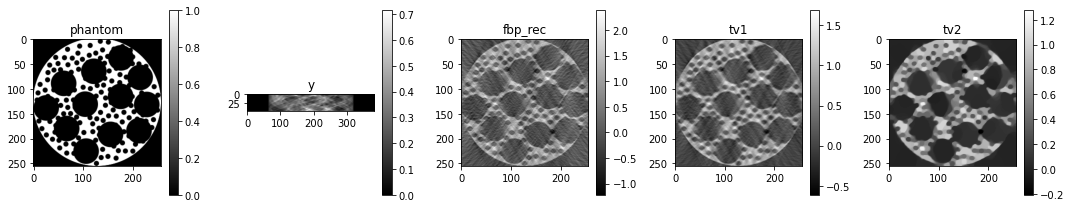

In [6]:
# Show example results on validation case
y = torch.load('foam_phantoms/xdesign/val/noisy/test_phantom_101_noisy.torch')
phantom = torch.load('foam_phantoms/xdesign/val/clean/test_phantom_101_clean.torch')

plot_imgs(phantom=phantom, y=y, fbp_rec=fbp(A, y), tv1=tv_min2d(A,y,lam=1e-10, num_iterations=1000),tv2=tv_min2d(A,y,lam=1e-2, num_iterations=1000))

In [8]:
torch.save(tv_min2d(A,y,lam=0.01, num_iterations=500).cpu().detach(), path + 'STV_TV_lam=0dot01.torch')
torch.save(tv_min2d(A,y,lam=1e-8, num_iterations=500).cpu().detach(), path + 'STV_TV_lam=1e-8.torch')

# Create dataloader

In [6]:
from pathlib import Path


class FoamCTDataset(torch.utils.data.Dataset):
    """Foam CT dataset.
       Inputs are noisy projections, and targets are clean phantoms (in volume domain)."""

    def __init__(self, root_dir, transform=None, device='cpu'):
        """
        Args:
            root_dir (string): Directory with all the images. Must have directories 'clean', and 'noisy'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = Path(root_dir).expanduser().resolve()
        self.transform = transform
        self.device = device

        self.input_dir = self.root_dir / 'noisy'
        self.target_dir = self.root_dir / 'clean'
        
        self.inputs = self.input_dir.glob("*")
        self.inputs = [str(p) for p in self.inputs]
        self.targets = self.target_dir.glob("*")
        self.targets = [str(p) for p in self.targets]
        
        if len(self.inputs) == 0:
            raise Exception(f"Input image stack is empty for path specification {root_dir}")
        if len(self.targets) == 0:
            raise Exception(f"Target image stack is empty for path specification {root_dir}")
        if len(self.inputs) != len(self.targets):
            raise Exception(f"Unequal number of inputs and targets provided in {root_dir}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_img_fn = self.inputs[idx]
        input_img = torch.load(input_img_fn).to(self.device)

        target_img_fn = self.targets[idx]
        target_img = torch.load(target_img_fn).to(self.device)
        return input_img, target_img

train_ds = FoamCTDataset('foam_phantoms/xdesign/train/', device='cuda:0')
val_ds = FoamCTDataset('foam_phantoms/xdesign/val/', device='cuda:0')
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False)

# Single TV + CNN

In [6]:
# Define the operators
lam = torch.tensor(0.001, dtype=torch.float32, device=dev, requires_grad=True)

tv_operator = TvMinOperator(projector=A, lam=lam, device='cuda:0',
                            n_iter=400)

In [7]:
# Define the CNN
net1 = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 1, 3, padding=1)
).to(device=dev)

nn_operator = PyTorchNn2dOperator(net1)

# Assemble the pipeline
surrcnn_pipeline = cxpl.SequentialPipeline([
    tv_operator,
    nn_operator
])

# Define optimizer with separate learning rate:
lr1 = 1e-6*5
lr2 = 1e-3
param_dict = {
    tv_operator: lr1,
    nn_operator: lr2
}

# Define optimizer
optimizer = ctxopt.PyTorchAdam(surrcnn_pipeline,
                target_parameters=param_dict,
                learning_rate=1e1)

class LambdaLogger:
    def __init__(self):
        self.lambdas = []
        self.recs = []
    
    def log(self, optimizer_object):
        lam = optimizer_object.pipeline.operators[0].parameters['lam']
        self.lambdas.append(lam.value.detach().clone().cpu())

logger = LambdaLogger()

In [8]:
# Optimize
optimal_params = optimizer.optimize(torch.nn.functional.mse_loss,
    data_loader=train_dl, n_iterations=200, callback=logger.log)

100%|██████████| 200/200 [5:14:38<00:00, 94.39s/it]  


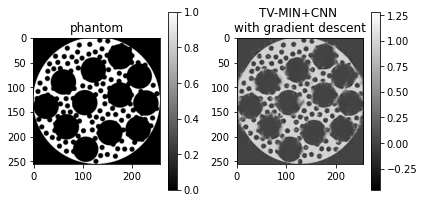

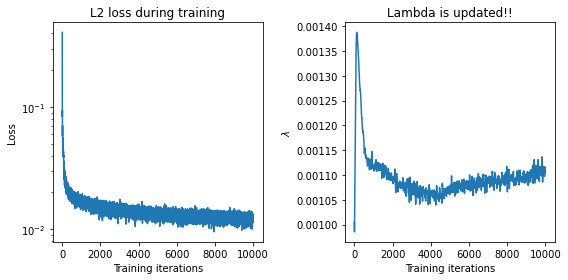

Final Loss: 0.012371759861707687


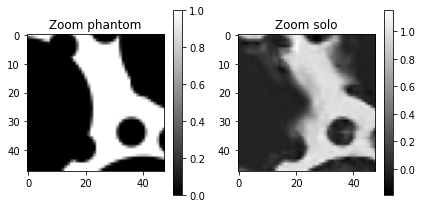

In [11]:
with torch.no_grad():
    for x in val_dl:
        val_inp, val_phantom = x
    out = surrcnn_pipeline(val_inp)

plot_imgs(
    **{
        "phantom":val_phantom,
        "TV-MIN+CNN \nwith gradient descent":out.detach().cpu(),
    },
    #clim=(-0.05, 1.1),
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title("L2 loss during training")
ax1.plot(optimizer.losses)
ax1.set_yscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss")

ax2.plot(logger.lambdas)
ax2.set_title("Lambda is updated!!")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("$\lambda$")
fig.tight_layout()
plt.show()

print("Final Loss:",optimizer.losses[-1])

plot_imgs(
    **{
        "Zoom phantom":val_phantom[0, 0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "Zoom solo":out[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
    },
)

In [12]:
torch.save(val_phantom.cpu().detach(), path + 'Foam_phantom.torch')
torch.save(out.cpu().detach(), path + 'SingleSurrogateTV_output.torch')
torch.save(out[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].cpu().detach(),
           path + 'SingleSurrogateTV_zoom.torch')
torch.save(torch.tensor(optimizer.losses), path + 'SingleSurrogateTV_losses.torch')
torch.save(torch.tensor(logger.lambdas), path + 'SingleSurrogateTV_lambda.torch')

In [13]:
## Test saving
surrcnn_pipeline.save("doubleTV_pipeline.pickle")
optimizer.save("doubleTV_pipeline_optimizer.pickle")
nn_operator.save("nn_operator2.pickle")

# Double TV + CNN

In [7]:
class DuoLambdaLogger:
    def __init__(self):
        self.lambdas1 = []
        self.lambdas2 = []
        self.recs = []
    
    def log(self, optimizer_object):
        lam1 = optimizer_object.pipeline.operators[1].parameters['lam']
        lam2 = optimizer_object.pipeline.operators[2].parameters['lam']
        self.lambdas1.append(lam1.value.detach().clone().cpu())
        self.lambdas2.append(lam2.value.detach().clone().cpu())

In [8]:
# Define the operators
lam1 = torch.tensor(0.001, dtype=torch.float32, device=dev, requires_grad=True)
tv_operator1 = TvMinOperator(projector=A, lam=lam1, device='cuda:0', n_iter=400)

lam2 = torch.tensor(1e-8, dtype=torch.float32, device=dev, requires_grad=True)
tv_operator2 = TvMinOperator(projector=A, lam=lam2, device='cuda:0', n_iter=400)

In [9]:
class SqueezeOperator(BaseOperator):                                                  
    def __init__(self, dim):                                                     
        super().__init__(device='cpu')                                                                                                                 
        self.dim = dim                                                                    
                                                                                          
    @property                                                                             
    def implements_batching(self):                                                        
        return True                                                                       
                                                                                          
    def __call__(self, data):
        return data.squeeze(self.dim)                 
                                                                                          
    def get_output_dimensions(self, input_dims):                                          
        return (float('inf'),)                                                            
                                                                                          
    def required_input_dimensions(self):                                                  
        return (float('inf'),)      

In [10]:
# Define the CNN
net2 = nn.Sequential(
    nn.Conv2d(2, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 1, 3, padding=1)
).to(device=dev)

nn_operator2 = PyTorchNn2dOperator(net2)
source_operator = VoidOperator()
squeeze_op = SqueezeOperator(dim=2)
logger2 = DuoLambdaLogger()


surrcnn_pipeline2 = cxpl.GraphPipeline([
    (source_operator, [tv_operator1, tv_operator2]),
    (tv_operator1, [squeeze_op]),
    (tv_operator2, [squeeze_op]),
    (squeeze_op, [nn_operator2]),
    (nn_operator2, []),
    ])

# Define optimizer with separate learning rate:
param_dict2 = {
    tv_operator1: 1e-4*0.2,
    tv_operator2: 1e-7,
    nn_operator2: 1e-3
}


# Define optimizer
optimizer3 = ctxopt.PyTorchAdam(surrcnn_pipeline2,
                target_parameters=param_dict2,
                learning_rate=1e1)

In [11]:
# Optimize
optimal_params = optimizer3.optimize(torch.nn.functional.mse_loss,
    data_loader=train_dl, n_iterations=200, callback=logger2.log)

100%|██████████| 200/200 [11:01:02<00:00, 198.31s/it] 


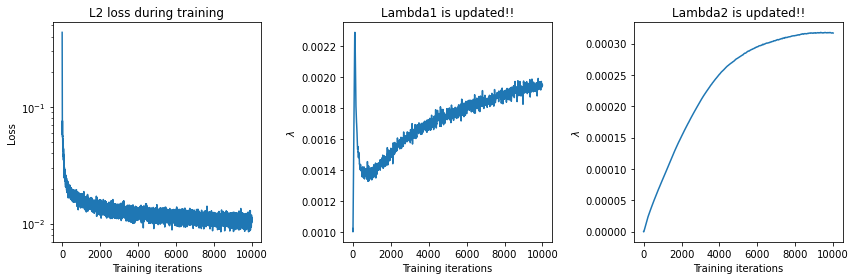

Final dual loss: 0.010631445795297623


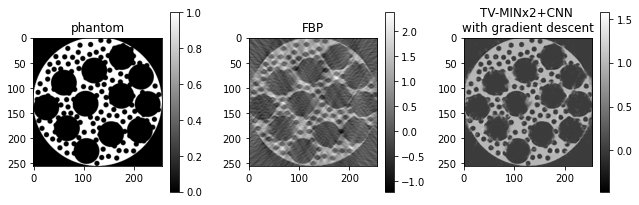

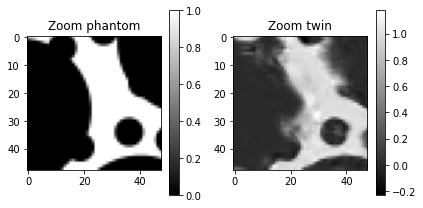

In [14]:
with torch.no_grad():
    for x in val_dl:
        val_inp, val_phantom = x
    out2 = surrcnn_pipeline2(val_inp)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.set_title("L2 loss during training")
ax1.plot(optimizer3.losses)
ax1.set_yscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss")

ax2.plot(logger2.lambdas1)
ax2.set_title("Lambda1 is updated!!")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("$\lambda$")

ax3.plot(logger2.lambdas2)
ax3.set_title("Lambda2 is updated!!")
ax3.set_xlabel("Training iterations")
ax3.set_ylabel("$\lambda$")

fig.tight_layout()
plt.show()

print("Final dual loss:",optimizer3.losses[-1])

plot_imgs(
    **{
        "phantom":val_phantom,
        "FBP":fbp(A, val_inp.squeeze(0)),
        "TV-MINx2+CNN \nwith gradient descent":out2.detach().cpu().numpy(),
        "TV-MIN+CNN \nwith gradient descent":out.detach().cpu().numpy(),
    },
    #clim=(-0.05, 1.1),
)

plot_imgs(
    **{
        "Zoom phantom":val_phantom[0, 0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "Zoom solo":out[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "Zoom twin":out2[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
    },
)

In [15]:
torch.save(torch.tensor(optimizer3.losses), path + 'DoubleSurrogateTV_losses.torch')
torch.save(torch.tensor(logger2.lambdas1), path + 'DoubleSurrogateTV_lambda1.torch')
torch.save(torch.tensor(logger2.lambdas2), path + 'DoubleSurrogateTV_lambda2.torch')
torch.save(out2.cpu().detach(), path + 'DoubleSurrogateTV_output.torch')
torch.save(fbp(A, val_inp.squeeze(0)).cpu().detach(), path + 'STV_FBP_raw.torch')

torch.save(val_phantom[0,vsize//4: vsize//4+48, vsize//4: vsize//4+48].cpu().detach(),
           path + 'STV_phantom_zoom.torch')
torch.save(out2[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].cpu().detach(),
           path + 'DoubleSurrogateTV_zoom.torch')

In [23]:
## Test saving
optimizer3.save("doubleTV_pipeline_optimizer.pickle")
nn_operator2.save("nn_operator2.pickle")

# FBP+LargeCNN

In [39]:
# Define the CNN
net3 = nn.Sequential(
    nn.Conv2d(1, 160, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(160, 96, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(96, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 1, 3, padding=1)
).to(device=dev)

nn_op3 = PyTorchNn2dOperator(net3)
fbp_operator = PyTorchFbpOperator(A)

# Assemble the pipeline
nn_pipeline = cxpl.SequentialPipeline([
    fbp_operator,
    nn_op3
])

# Define optimizer with separate learning rate:
lr2 = 1e-3
param_dict3 = {
    nn_op3: lr2
}

# Define optimizer
optimizer5 = ctxopt.PyTorchAdam(nn_pipeline,
                target_parameters=param_dict3,
                learning_rate=1e1)

In [40]:
# Optimize
optimal_params = optimizer5.optimize(torch.nn.functional.mse_loss,
    data_loader=train_dl, n_iterations=200)

100%|██████████| 200/200 [04:39<00:00,  1.40s/it]


torch.Size([1, 1, 50, 384]) torch.Size([1, 1, 256, 256])


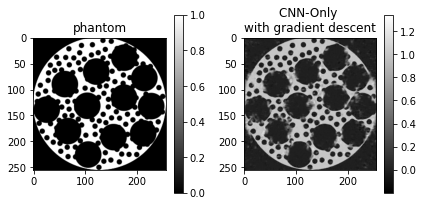

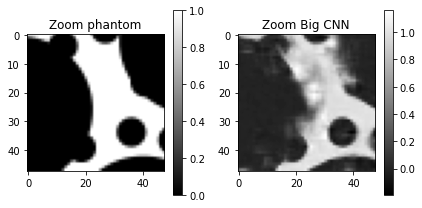

Final Loss: 0.011516354978084564


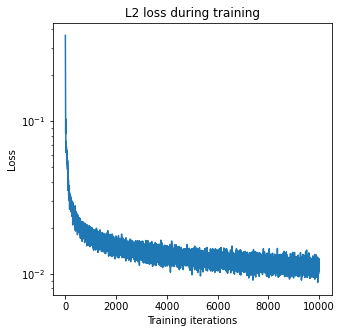

In [46]:
with torch.no_grad():
    for x in val_dl:
        val_inp = x[0]
        val_phantom = x[1]
    out3 = nn_pipeline(val_inp)

plot_imgs(
    **{
        "phantom":val_phantom,
        "CNN-Only \nwith gradient descent":out3.detach().cpu(),
    },
    #clim=(-0.05, 1.1),
)

plot_imgs(
    **{
        "Zoom phantom":val_phantom[0, 0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "Zoom stacked approach":out2[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "Zoom Big CNN":out3[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
    },
    #clim=(-0.05, 1.1),
)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.set_title("L2 loss during training")
ax1.plot(optimizer5.losses)
ax1.set_yscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss")

print("Final Loss:",optimizer5.losses[-1])

In [48]:
torch.save(out3.cpu().detach(), path + 'STV_BigCNN_output.torch')
torch.save(out3[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].cpu().detach(),path+'STV_BigCNN_output_zoom.torch')
torch.save(torch.tensor(optimizer5.losses), path + 'STV_BigCNN_losses.torch')

## Testing saving and loading

In [ ]:
## Test saving
surrcnn_pipeline.save("test_pipeline.pickle")

In [ ]:
## Test loading
surrcnn_pipeline = cxpl.SequentialPipeline([])
surrcnn_pipeline.load("test_pipeline.pickle")

# FBP + SmallCNN

In [20]:
# Define the CNN
net = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 1, 3, padding=1)
).to(device=dev)

nn_operator = PyTorchNn2dOperator(net)
fbp_operator = PyTorchFbpOperator(A)

# Assemble the pipeline
fbpcnn_pipeline = cxpl.SequentialPipeline([
    fbp_operator,
    nn_operator
])

# Define optimizer with separate learning rate:
lr2 = 1e-3
param_dict = {
    nn_operator: lr2
}

# Define optimizer
optimizer6 = ctxopt.PyTorchAdam(fbpcnn_pipeline,
                target_parameters=param_dict,
                learning_rate=1e1)

In [21]:
# Optimize
optimal_params = optimizer6.optimize(torch.nn.functional.mse_loss,
    data_loader=train_dl, n_iterations=200)

100%|██████████| 200/200 [01:50<00:00,  1.82it/s]


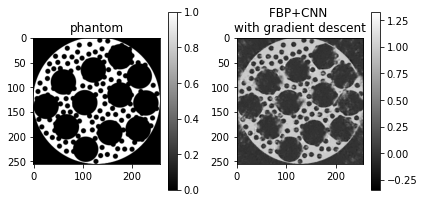

Final Loss: 0.01661660522222519


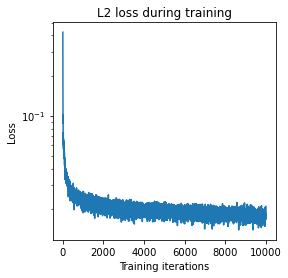

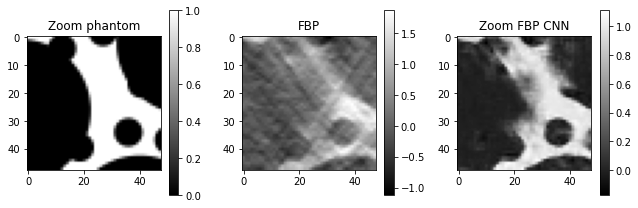

In [22]:
with torch.no_grad():
    for x in val_dl:
        val_inp, val_phantom = x
    out4 = fbpcnn_pipeline(val_inp)

plot_imgs(
    **{
        "phantom":val_phantom,
        "FBP+CNN \nwith gradient descent":out4.detach().cpu(),
    },
    #clim=(-0.05, 1.1),
)

fig, ax1 = plt.subplots(1, figsize=(4, 4))
ax1.set_title("L2 loss during training")
ax1.plot(optimizer6.losses)
ax1.set_yscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss")

print("Final Loss:",optimizer6.losses[-1])

plot_imgs(
    **{
        "Zoom phantom":val_phantom[0, 0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "FBP":fbp(A, val_inp.squeeze(0))[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
        "Zoom FBP CNN":out4[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].detach().cpu(),
    }
)

In [23]:
with torch.no_grad():
    for x in val_dl:
        val_inp, val_phantom = x

torch.save(val_inp.cpu().detach(), path + 'STV_FBPCNN_input.torch')
torch.save(val_phantom.cpu().detach(), path + 'STV_phantom.torch')
torch.save(val_phantom[:,:,vsize//4: vsize//4+48, vsize//4: vsize//4+48].cpu().detach(),
           path + 'STV_phantom_zoom.torch')
torch.save(out4.cpu().detach(), path + 'STV_FBPCNN_output.torch')
torch.save(out4[0, vsize//4: vsize//4+48, vsize//4: vsize//4+48].cpu().detach(),path+'STV_FBPCNN_output_zoom.torch')
torch.save(torch.tensor(optimizer6.losses), path + 'STV_FBPCNN_losses.torch')

# Analysis of methods

In [ ]:
from autodiffCT.image.segmentation import ThresholdOperator

thr_op = ThresholdOperator(n_classes=2, bins=128, device='cpu', re_init_at_call=True, gamma=1e4)

with torch.no_grad():
    fbp_thr = thr_op(out4)
    large_fbp_thr = thr_op(out3)
    single_tv_thr = thr_op(out)
    double_tv_thr = thr_op(out2)

    loss1 = torch.nn.functional.mse_loss(fbp_thr, phantom)
    loss2 = torch.nn.functional.mse_loss(single_tv_thr, phantom)
    loss3 = torch.nn.functional.mse_loss(double_tv_thr, phantom)
    loss4 = torch.nn.functional.mse_loss(large_fbp_thr, phantom)
    print(loss1, loss2, loss3, loss4)

tensor(0.03512573) tensor(0.03746816) tensor(0.03681842)


In [49]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [54]:
print(get_n_params(net1))# Small network + Single TV
print(get_n_params(net2))# Small network + Double TV
print(get_n_params(net))# Small FBP network
print(get_n_params(net3))# Large FBP network

19393
19969
195873


In [59]:
valpath = path

with torch.no_grad():
    for x in val_dl:
        val_inp, val_phantom = x
    val_phantom = val_phantom.cpu().detach()
    
    fbpsmall = torch.load(valpath + 'STV_FBPCNN_output.torch').cpu().detach()
    tv1x = torch.load(valpath + 'SingleSurrogateTV_output.torch').cpu().detach()
    tv2x = torch.load(valpath + 'DoubleSurrogateTV_output.torch').cpu().detach()
    fbplarge = torch.load(valpath + 'STV_BigCNN_output.torch').cpu().detach()

    print('Small FBP+CNN:', torch.nn.functional.mse_loss(fbpsmall, val_phantom[0]))
    print('Single TV+CNN:', torch.nn.functional.mse_loss(tv1x, val_phantom[0]))
    print('Double TV+CNN:', torch.nn.functional.mse_loss(tv2x, val_phantom[0]))
    print('Large FBP+CNN:', torch.nn.functional.mse_loss(fbplarge, val_phantom[0]))

Small FBP+CNN: tensor(0.02322405)
Single TV+CNN: tensor(0.01863361)
Double TV+CNN: tensor(0.01805044)
Large FBP+CNN: tensor(0.02268498)
